# <p style="background-color: #009688; font-family:calibri; color:white; font-size:120%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Project | Movie Reviews Classification(Part 2)</p>

<div style="border-radius:10px; padding: 15px; background-color: #E3F2FD; font-size:120%; text-align:left">
  
### Table of Contents

1. [Data Overview](#data-overview)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Development](#model-development)
     - [Fast Encoding](#fast-encoding)
     - [Building Transformer Model](#transformer)
4. [Results and Analysis](#results-and-analysis)
5. [Conclusion](#conclusion)

</div>

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">1. Data Overview</p><a id="data-overview"></a>
    
The IMDB dataset contains 50,000 movie reviews, specifically curated for natural language processing (NLP) and text analytics tasks. This dataset is designed for binary sentiment classification and offers a significant amount of data compared to previous benchmarks.

**Dataset Overview:**
- **Training Set:** 25,000 movie reviews
- **Testing Set:** 25,000 movie reviews

The goal is to predict the sentiment of each review, classifying them as either positive or negative. This task can be approached using traditional classification methods or advanced deep learning algorithms.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">1.1 Loading the necessary libraries</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">1.2 Importing the dataset</p>

In [3]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">2. Data Preprocessing</p><a id="data-preprocessing"></a>

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


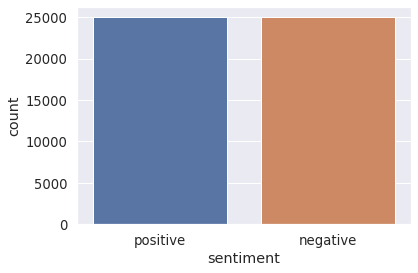

In [5]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

The Dataset is balanced.

In [6]:
df.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

#### WHAT ARE STOPWORDS?

- Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.

In [7]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">2.1 Basic Data Cleaning</p>

In [8]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [9]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">2.2 Wordcloud for Positive Text</p>

In [10]:
sns.set(style = "white" , font_scale = 1.2)

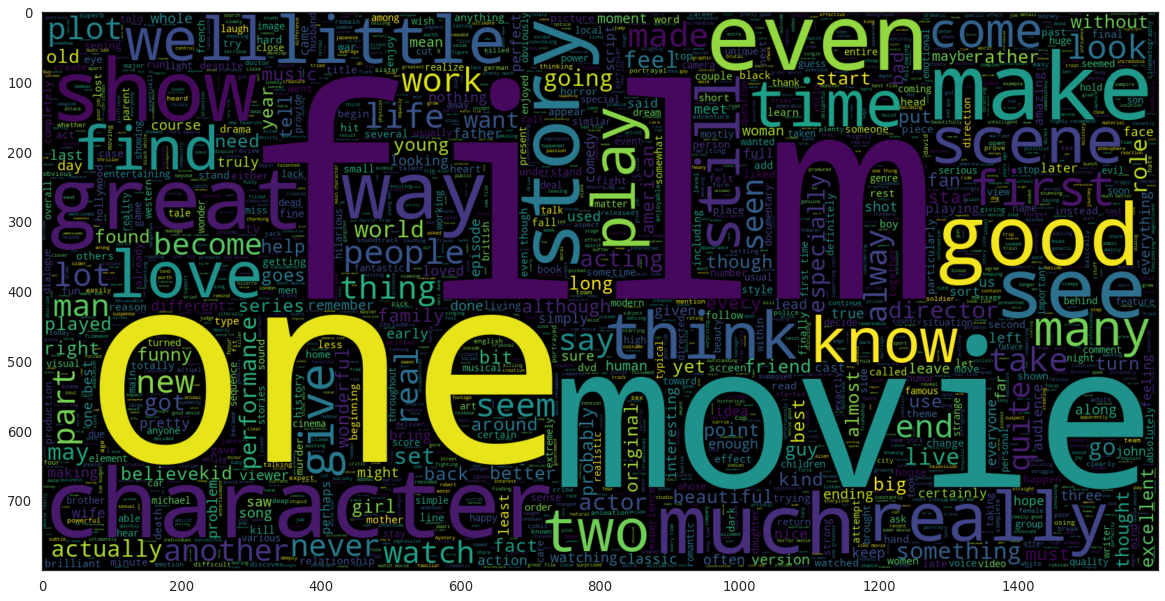

In [11]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">2.3 Wordcloud for Negative Text</p>

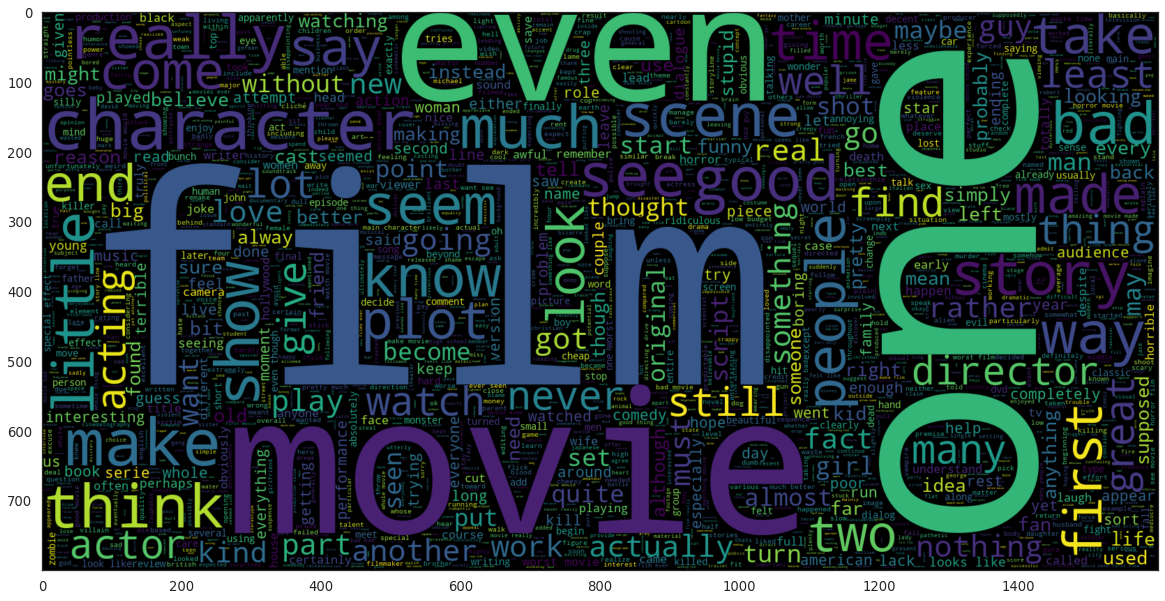

In [12]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">2.4 Number of characters in texts</p>

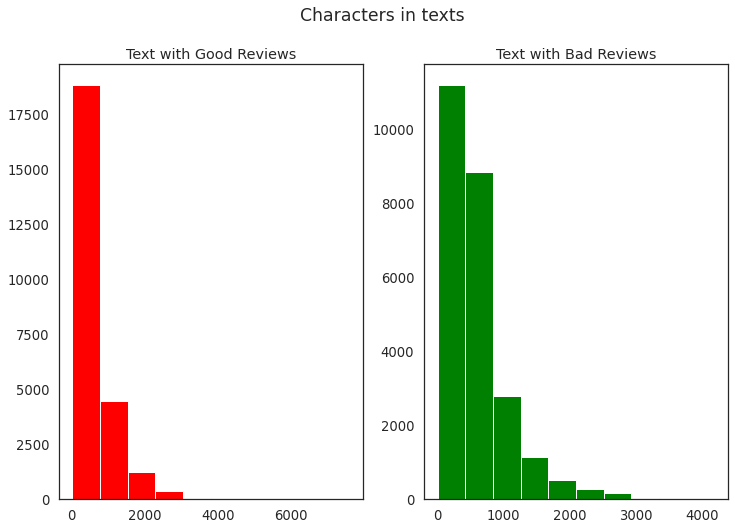

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

#### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">2.5 Average Word Length in each text</p>

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

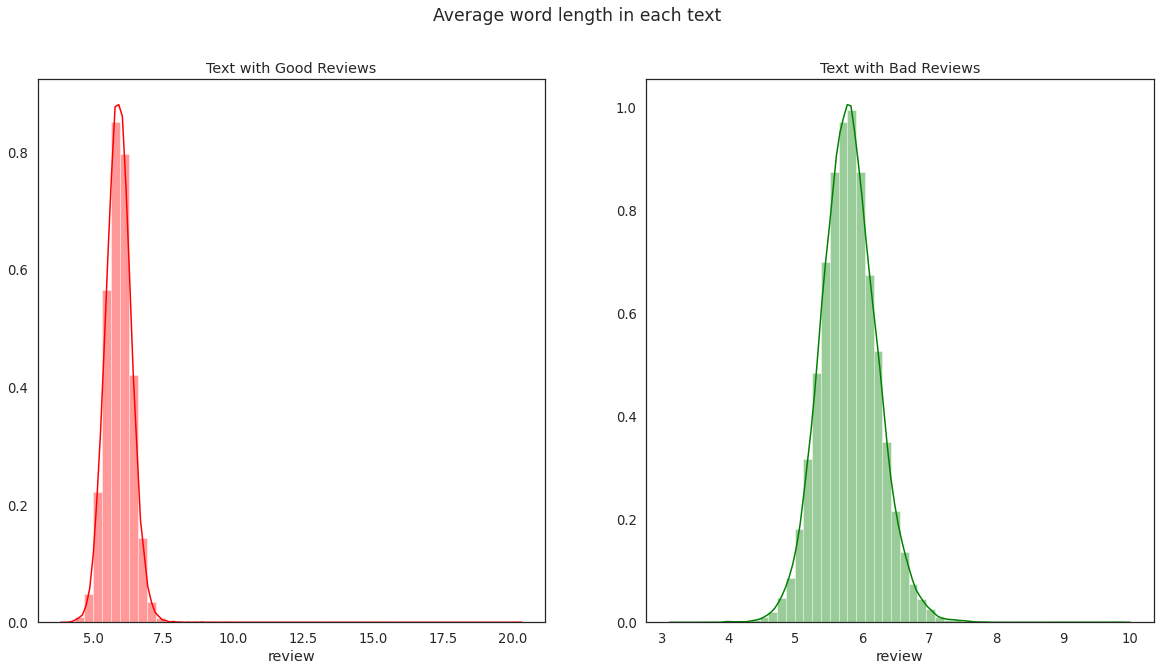

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['sentiment']==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
word=df[df['sentiment']==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

In [15]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [16]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 61496,
 'film': 55088,
 'one': 45067,
 'like': 37303,
 'would': 23815,
 'even': 23720,
 'good': 23475,
 'really': 21806,
 'see': 20906,
 'get': 17692}

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

The most common words in the corpus indicate that the text is likely related to movie reviews or discussions, with frequent mentions of words like "movie," "film," "good," and "like." The presence of words such as "one," "would," and "really" suggests that the corpus includes personal opinions and subjective assessments.

In [17]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">3. Model Development</p><a id="model-development"></a>

In [21]:
x_train,x_test,y_train,y_test = train_test_split(df.review,df.sentiment,random_state = 0 , stratify = df.sentiment)

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

### <p style="background-color: #009688; font-family:calibri; color:white; font-size:120%; font-family:Verdana; text-align:center; border-radius:15px 50px;">3.1 Fast Encoding</p><a id="fast-encoding"></a>

In the context of Natural Language Processing (NLP) using models like BERT, **fast encoding** refers to an optimized method for efficiently converting raw text into a format suitable for model input, particularly when working with large datasets or requiring high-speed processing. This process is crucial for handling extensive text corpora, such as the IMDB movie reviews dataset, where traditional encoding methods may be too slow or resource-intensive.

### Key Aspects of Fast Encoding

1. **Purpose and Efficiency:**
   Fast encoding aims to speed up the text preprocessing pipeline by reducing the time it takes to convert raw text into tokenized sequences that BERT or other models can understand. This efficiency is particularly beneficial when dealing with large-scale datasets or when needing to perform real-time predictions.

2. **Tokenization:**
   Fast encoding typically involves tokenizing text into subword units, which are then mapped to corresponding integer indices based on a pre-trained tokenizer’s vocabulary. This tokenization process converts raw text into a sequence of tokens that the model can process.

3. **Padding and Truncation:**
   During fast encoding, sequences are often padded or truncated to ensure they meet the model's input requirements. Padding adds tokens to shorter sequences to reach a specified length, while truncation shortens longer sequences to fit within the maximum allowed length. This step helps standardize input sizes and ensures compatibility with BERT’s architecture.

4. **Handling Special Tokens:**
   Special tokens such as `[CLS]` (classification token) and `[SEP]` (separator token) are added to the input sequences. These tokens play specific roles in various NLP tasks, such as indicating the start of a sequence or separating segments. Fast encoding includes these tokens in the preprocessing pipeline to prepare the input data appropriately for the model.

5. **Efficient Processing:**
   Fast encoding methods are often designed to handle batches of text efficiently, processing multiple sequences simultaneously. This batch processing capability significantly reduces the time required for encoding large volumes of text.

In [22]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [23]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [24]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)

### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">3.2 Building Transformer Model</p><a id="transformer"></a>

In [25]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [27]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 400)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 400, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

The model is a text classification architecture based on the DistilBERT model, which has 66,363,649 total parameters, all of which are trainable. It consists of an input layer that accepts sequences of length 400, a DistilBERT layer that processes these sequences to produce embeddings of size 768, and a dense output layer that produces a single output per input sequence. The large number of parameters indicates that the model is capable of capturing complex patterns in the data, leveraging the pre-trained DistilBERT embeddings to enhance performance on the classification task.

In [28]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 5)

Epoch 1/5
1172/1172 [==============================] - 1007s 859ms/step - loss: 0.3551 - accuracy: 0.8425 - val_loss: 0.2819 - val_accuracy: 0.8810
Epoch 2/5
1172/1172 [==============================] - 1005s 858ms/step - loss: 0.2396 - accuracy: 0.9026 - val_loss: 0.2666 - val_accuracy: 0.8891
Epoch 3/5
1172/1172 [==============================] - 1006s 858ms/step - loss: 0.1522 - accuracy: 0.9409 - val_loss: 0.3178 - val_accuracy: 0.8834
Epoch 4/5
1172/1172 [==============================] - 1007s 859ms/step - loss: 0.0815 - accuracy: 0.9702 - val_loss: 0.3886 - val_accuracy: 0.8840
Epoch 5/5
1172/1172 [==============================] - 1008s 860ms/step - loss: 0.0462 - accuracy: 0.9839 - val_loss: 0.5063 - val_accuracy: 0.8754


### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">4. Results and Analysis</p><a id="results-and-analysis"></a>

In [29]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

391/391 [==============================] - 98s 250ms/step - loss: 0.5063 - accuracy: 0.8754
Accuracy of the model on Testing Data is -  87.5440001487732 %


<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

The model achieved an accuracy of approximately 87.54% on the testing data, indicating strong performance in correctly classifying the text.

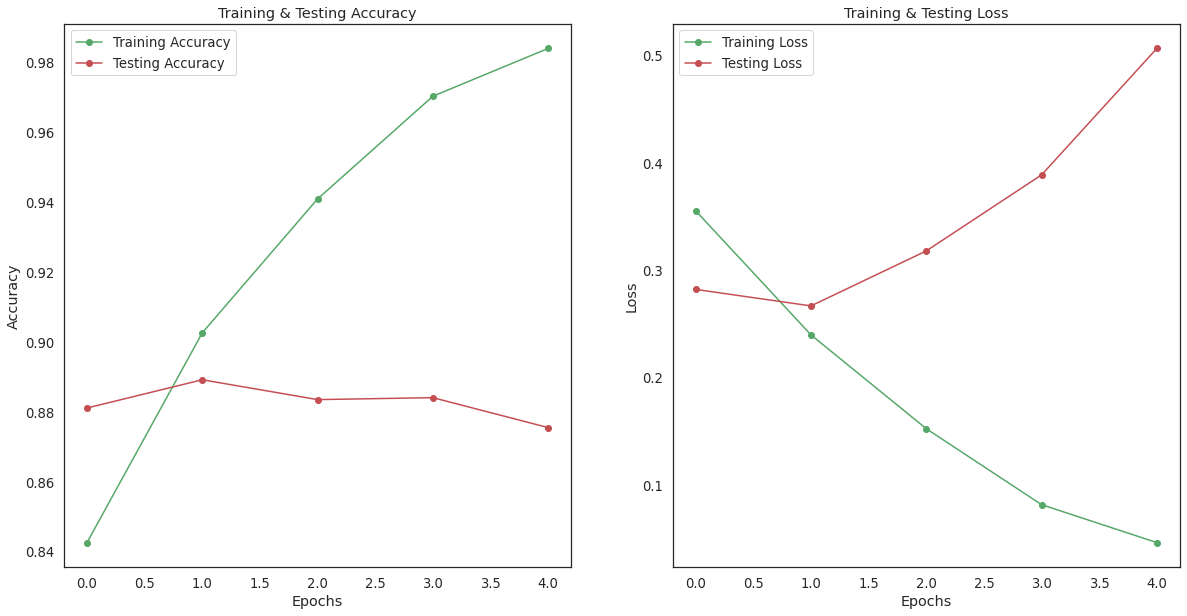

In [31]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

The training process shows that the model's accuracy improved consistently over the first few epochs, reaching 97.02% by the fourth epoch, while the validation accuracy also increased, peaking at 88.91%. However, the validation loss began to rise significantly from the third epoch onward, suggesting the onset of overfitting. By the final epoch, the model's training accuracy was 98.39%, but the validation accuracy slightly decreased to 87.54%, indicating that the model may be overfitting to the training data.

In [32]:
pred = model.predict(x_test)
pred[:5]

array([[9.8409986e-01],
       [5.3526387e-06],
       [5.9532784e-03],
       [1.6733730e-04],
       [2.0347910e-01]], dtype=float32)

In [33]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [0]])

In [34]:
print(classification_report(y_test, pred, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.85      0.92      0.88      6250
Good Reviews       0.91      0.83      0.87      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

The classification report shows balanced performance across both classes, with precision, recall, and F1-score values close to 0.88 on average. The model performs well with high accuracy of 88% and demonstrates effective classification for both "Bad Reviews" and "Good Reviews," although precision is slightly higher for "Good Reviews" while recall is higher for "Bad Reviews."

In [35]:
cm = confusion_matrix(y_test,pred)
cm

array([[5746,  504],
       [1053, 5197]])

Text(62.5, 0.5, 'Actual')

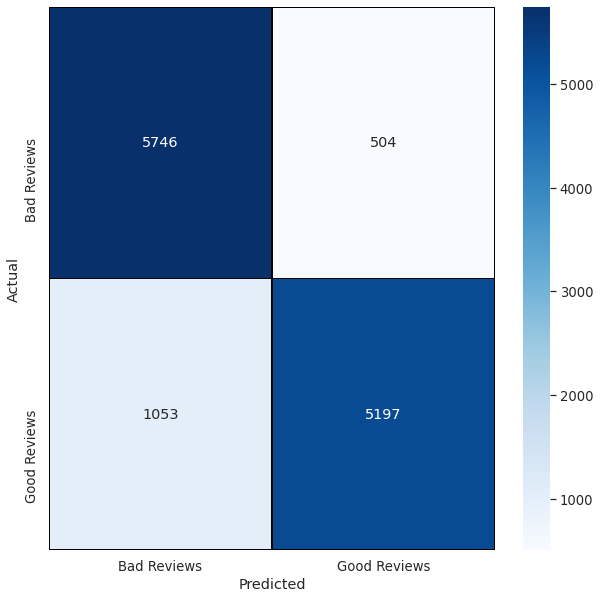

In [36]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

### <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">5. Conclusion</p><a id="conclusion"></a>

The BERT Transformer model demonstrated robust performance in sentiment analysis, as evidenced by its ability to accurately classify text with an overall accuracy of approximately 87.54%. The training and validation loss trends indicate that the model effectively learned from the data, with validation accuracy peaking at 88.91% in the second epoch before slightly declining in subsequent epochs. The classification report highlights a balanced performance across both "Bad Reviews" and "Good Reviews," with precision and recall values close to 0.88 on average. This reflects BERT's capability to handle complex language patterns and provides a solid foundation for sentiment classification tasks. Despite some fluctuations in validation metrics, BERT's performance remains consistently high, validating its effectiveness in natural language processing tasks.